# Cài đặt thư viện

In [1]:
# Cài đặt các thư viện cần thiết
!uv pip install transformers torch pandas scikit-learn tqdm





                         ./o.
                       ./sssso-
                     `:osssssss+-
                   `:+sssssssssso/.
                 `-/ossssssssssssso/.
               `-/+sssssssssssssssso+:`
             `-:/+sssssssssssssssssso+/.
           `.://osssssssssssssssssssso++-
          .://+ssssssssssssssssssssssso++:
        .:///ossssssssssssssssssssssssso++:
      `:////ssssssssssssssssssssssssssso+++.
    `-////+ssssssssssssssssssssssssssso++++-
     `..-+oosssssssssssssssssssssssso+++++/`
       ./++++++++++++++++++++++++++++++/:.
      `:::::::::::::::::::::::::------``
┌─────────────── Hardware ────────────────┐
 PC: superkid@loihnt-nitroan51545
│ ├󰍛 CPU: AMD Ryzen 5 5600H
│ ├󰍛 GPU: NVIDIA GeForce GTX 1650 Mobile / Max-Q [Discrete]
│ ├󰍛 GPU: AMD Radeon Vega Series / Radeon Vega Mobile Series [Integrated]
└ └󰍛 Memory: 11.20 GiB / 14.97 GiB (75%)
└──────────────────────────────────────────┘

┌─────────────── Software ────────────────┐
 OS: EndeavourOS x86_64


# Import và Cấu hình

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time
from tqdm.auto import tqdm # Tự động chọn thanh tiến trình phù hợp

# ================= CẤU HÌNH =================
INPUT_FILE = '../dataset/articles_clean.csv'  # <--- Đổi tên file nếu file của bạn khác
MODEL_NAME = "vinai/phobert-base"
SAVE_PATH = "phobert_classifier.pth"

# Cấu hình Training
MAX_LEN = 128       # Độ dài tối đa của câu (128 là đủ cho tin tức, max là 256)
BATCH_SIZE = 16     # Giảm xuống 8 nếu bị lỗi "Out of Memory" (OOM)
EPOCHS = 3          # Số vòng học
LEARNING_RATE = 2e-5

# Tùy chọn: Chỉ lấy một phần dữ liệu để test code cho nhanh?
# Set = None nếu muốn train hết 100% dữ liệu (Sẽ rất lâu, khoảng vài tiếng)
# Set = 5000 để chạy thử xem code có lỗi không
SAMPLE_SIZE = None 

# Kiểm tra GPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print(f'✅ Đã tìm thấy GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('⚠️ Không thấy GPU, sẽ chạy bằng CPU (Rất chậm!)')

/home/loiancut/workspace/fake-news-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Đã tìm thấy GPU: NVIDIA GeForce GTX 1650


# Load & Chuẩn bị dữ liệu

In [3]:
# 1. Load dữ liệu
print(f"📂 Đang đọc file {INPUT_FILE}...")
try:
    df = pd.read_csv(INPUT_FILE)
    print(f"   Tổng số dòng: {len(df)}")
except FileNotFoundError:
    print(f"❌ Không tìm thấy file {INPUT_FILE}. Hãy kiểm tra lại tên file!")
    
# 2. Tự động tìm tên cột chứa nội dung
possible_text_cols = ['content', 'text', 'news', 'article', 'body']
col_text = next((col for col in possible_text_cols if col in df.columns), None)

# Tự động tìm tên cột nhãn
possible_label_cols = ['label', 'target', 'is_fake']
col_label = next((col for col in possible_label_cols if col in df.columns), None)

if col_text and col_label:
    print(f"✅ Đã xác định cột nội dung: '{col_text}'")
    print(f"✅ Đã xác định cột nhãn: '{col_label}'")
else:
    raise ValueError(f"❌ Không tìm thấy tên cột phù hợp. Cột hiện có: {list(df.columns)}")

# 3. Lấy mẫu (nếu cần)
if SAMPLE_SIZE and SAMPLE_SIZE < len(df):
    print(f"⚠️ Đang lấy mẫu {SAMPLE_SIZE} dòng để test code...")
    df = df.sample(SAMPLE_SIZE, random_state=42)

texts = df[col_text].values
labels = df[col_label].values

print(f"📊 Dữ liệu sẵn sàng: {len(texts)} mẫu.")

📂 Đang đọc file ../dataset/articles_clean.csv...
   Tổng số dòng: 96239
✅ Đã xác định cột nội dung: 'content'
✅ Đã xác định cột nhãn: 'label'
📊 Dữ liệu sẵn sàng: 96239 mẫu.
   Tổng số dòng: 96239
✅ Đã xác định cột nội dung: 'content'
✅ Đã xác định cột nhãn: 'label'
📊 Dữ liệu sẵn sàng: 96239 mẫu.


# Tokenizer

In [ ]:
print("🤖 Đang tải Tokenizer từ VinAI...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Hàm mã hóa
def encode_batch(data_texts, max_len=128):
    input_ids = []
    attention_masks = []
    
    print("🚀 Bắt đầu mã hóa (Tokenizing)...")
    for text in tqdm(data_texts):
        encoded = tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Thực hiện mã hóa
input_ids, attention_masks = encode_batch(texts, MAX_LEN)
labels = torch.tensor(labels)

print("✅ Đã mã hóa xong!")

🤖 Đang tải Tokenizer từ VinAI...
🚀 Bắt đầu mã hóa (Tokenizing)...
🚀 Bắt đầu mã hóa (Tokenizing)...


 59%|█████▉    | 57022/96239 [01:53<01:18, 502.32it/s]

# Chia tập Train / Val & Tạo DataLoader

In [11]:
# Chia train (85%) - validation (15%)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.15, stratify=labels
)
train_masks, val_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=42, test_size=0.15, stratify=labels
)

# Tạo DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

print(f"🔹 Train set: {len(train_inputs)}")
print(f"🔹 Val set:   {len(val_inputs)}")

🔹 Train set: 81803
🔹 Val set:   14436


# Định nghĩa Model PhoBERT Classifier

In [1]:
class PhoBertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(PhoBertClassifier, self).__init__()
        # Load PhoBERT gốc
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        
        # Nếu muốn train nhanh hơn thì đóng băng BERT (freeze_bert=True)
        # Nhưng để độ chính xác cao nhất thì nên để False (Fine-tune toàn bộ)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
                
        # Lớp phân loại tùy chỉnh
        self.classifier = nn.Sequential(
            nn.Linear(768, 512), # 768 là hidden size của PhoBERT base
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 2)    # Output 2 lớp: Fake (0) và Real (1)
        )

    def forward(self, input_ids, attention_mask):
        # Forward qua BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Lấy vector [CLS] đại diện cho cả câu
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        # Forward qua lớp phân loại
        logits = self.classifier(cls_output)
        return logits

# Khởi tạo model
model = PhoBertClassifier(freeze_bert=False)
model.to(device) # Đưa model vào GPU

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()

print("✅ Đã khởi tạo Model thành công.")

NameError: name 'nn' is not defined

# Bắt đầu Training

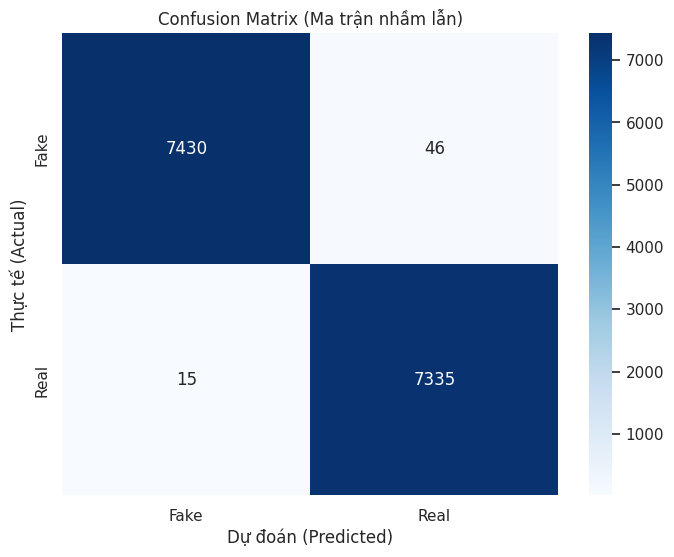

              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      7476
        Real       0.99      1.00      1.00      7350

    accuracy                           1.00     14826
   macro avg       1.00      1.00      1.00     14826
weighted avg       1.00      1.00      1.00     14826



In [ ]:
import random

# Hàm tính độ chính xác
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Set seed để kết quả giống nhau mỗi lần chạy
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

print("🚀 BẮT ĐẦU TRAINING...")

for epoch_i in range(0, EPOCHS):
    print(f'\n======== Epoch {epoch_i + 1} / {EPOCHS} ========')
    print('Training...')
    
    t0 = time.time()
    total_train_loss = 0
    model.train()

    # Thanh tiến trình cho epoch này
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_i+1}")

    for step, batch in enumerate(progress_bar):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        
        logits = model(b_input_ids, b_input_mask)
        loss = loss_fn(logits, b_labels)
        
        total_train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        # Cập nhật loss lên thanh tiến trình
        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  ✅ Average training loss: {avg_train_loss:.4f}")
    
    # ================= VALIDATION =================
    print("Running Validation...")
    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    val_preds = []
    val_true = []

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask)
            loss = loss_fn(logits, b_labels)
            
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        # Lưu lại để tính F1-Score
        val_preds.extend(np.argmax(logits, axis=1).flatten())
        val_true.extend(label_ids.flatten())

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print(f"  ✅ Accuracy: {avg_val_accuracy:.4f}")
    
    # In báo cáo chi tiết
    print(classification_report(val_true, val_preds, target_names=['Fake', 'Real']))

print("\n🏁 TRAINING COMPLETE!")

# Lưu Model & Test thử

In [ ]:
# Lưu model
print(f"💾 Đang lưu model vào {SAVE_PATH}...")
torch.save(model.state_dict(), SAVE_PATH)
print("✅ Đã lưu xong.")

# Test thử một câu
def predict_news(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.nn.functional.softmax(logits, dim=1)
        
    fake_prob = probs[0][0].item()
    real_prob = probs[0][1].item()
    
    print(f"\n📰 Input: {text[:100]}...")
    print(f"📊 Dự đoán: Real: {real_prob:.1%} | Fake: {fake_prob:.1%}")
    if real_prob > fake_prob:
        return "REAL"
    else:
        return "FAKE"

# Thử nghiệm
predict_news("Bộ y tế khuyến cáo người dân đeo khẩu trang nơi công cộng.")
predict_news("Người ngoài hành tinh vừa đáp xuống hồ Gươm ăn kem Tràng Tiền.")